# Cifar100

## Recuperation des données

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Chargement du dataset CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Récupération des noms des classes
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar',
    'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
# Création d'un dictionnaire pour stocker une image de chaque classe
one_image_per_class = {}

## Affichage une image par classe

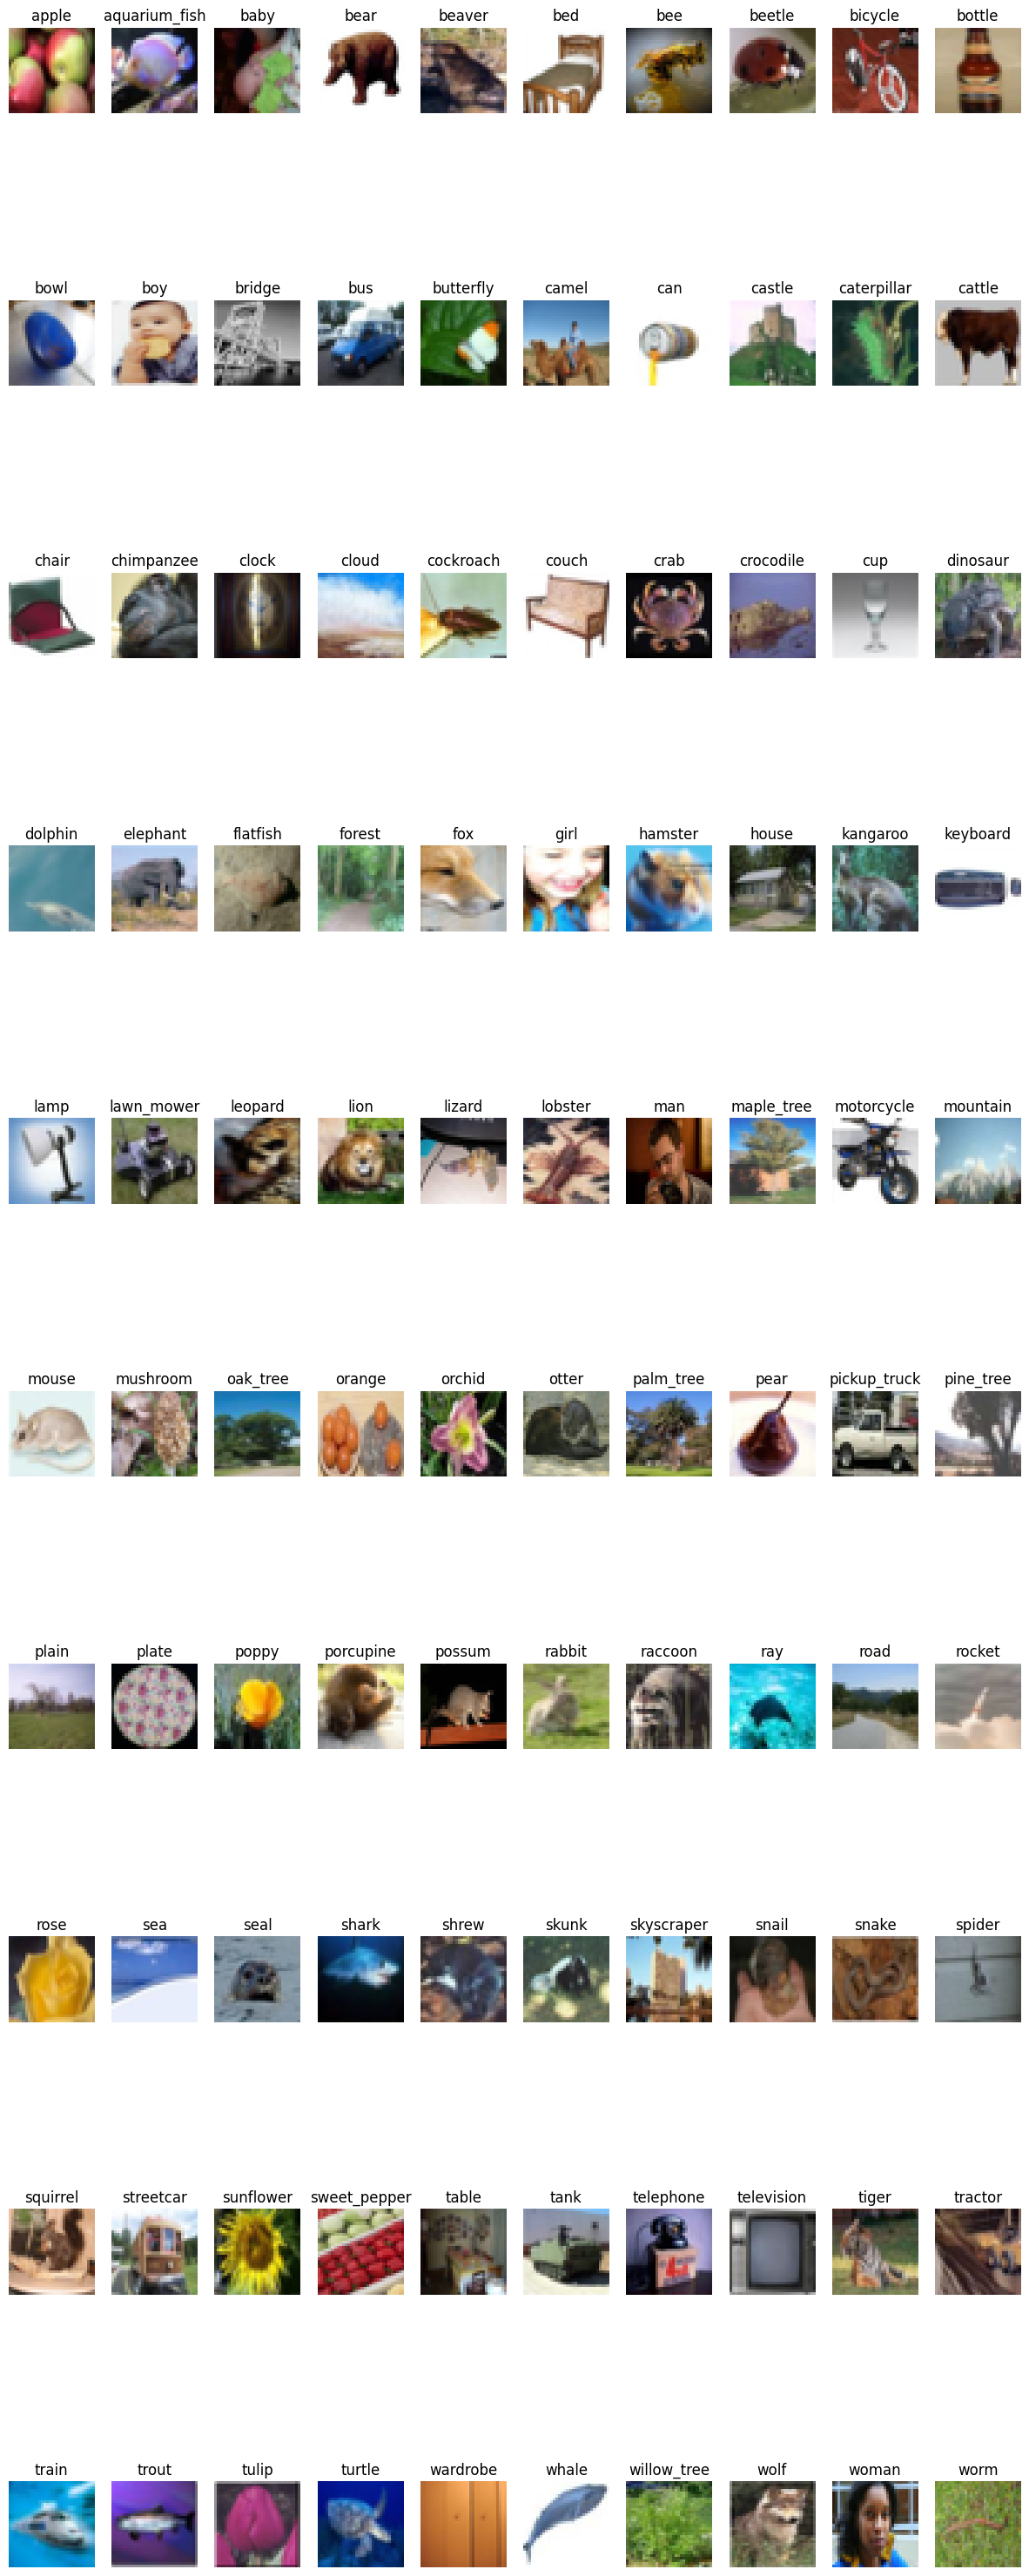

In [7]:
# Trouver une image aléatoire pour chaque classe
for i in range(100):  # Remplacez 10 par 100 pour CIFAR-100
    indices = np.where(y_train == i)[0]
    random_index = np.random.choice(indices)
    one_image_per_class[i] = x_train[random_index]

# Affichage d'une image de chaque classe
plt.figure(figsize=(15, 40))  # Ajustez la taille de la figure en conséquence

for i in range(100):  # Remplacez 10 par 100 pour CIFAR-100
    plt.subplot(10, 10, i + 1)  # Ajustez le nombre de lignes et de colonnes en conséquence
    plt.imshow(one_image_per_class[i])
    plt.title(class_names[i])
    plt.axis('off')

plt.show()


## Pretraitement

In [8]:
# Prétraitement des données
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 100)  # Remplacez 10 par 100 pour CIFAR-100
y_test = to_categorical(y_test, 100)  # Remplacez 10 par 100 pour CIFAR-100


## Listes des models non pré entrainés

In [9]:
# Liste des architectures de modèles à tester avec leurs noms
models_to_test = [
    {
        'name': 'CNN simple',
        'model': Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(100, activation='softmax')
        ])
    },
    # {
    #     'name': 'LeNet',
    #     'model': Sequential([
    #         Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),  # Modification ici pour 3 canaux
    #         MaxPooling2D((2, 2)),
    #         Conv2D(16, (5, 5), activation='relu'),
    #         MaxPooling2D((2, 2)),
    #         Flatten(),
    #         Dense(120, activation='relu'),
    #         Dense(84, activation='relu'),
    #         Dense(100, activation='softmax')
    #     ])
    # },
    # {
    #     'name': 'AlexNet',
    #     'model': Sequential([
    #         # Première couche de convolution
    #         Conv2D(96, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    #         MaxPooling2D((2, 2)),
    #         BatchNormalization(),
            
    #         # Deuxième couche de convolution
    #         Conv2D(256, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2)),
    #         BatchNormalization(),
            
    #         # Troisième couche de convolution
    #         Conv2D(384, (3, 3), activation='relu', padding='same'),
            
    #         # Quatrième couche de convolution
    #         Conv2D(384, (3, 3), activation='relu', padding='same'),
            
    #         # Cinquième couche de convolution
    #         Conv2D(256, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2)),
    #         BatchNormalization(),
            
    #         # Couche complètement connectée
    #         Flatten(),
    #         Dense(4096, activation='relu'),
    #         Dropout(0.5),
            
    #         # Deuxième couche complètement connectée
    #         Dense(4096, activation='relu'),
    #         Dropout(0.5),
            
    #         # Couche de sortie
    #         Dense(100, activation='softmax')
    #     ])
    # },
    

    # {
    #     'name': 'VGGNet',
    #     'model': Sequential([
    #         # Bloc 1
    #         Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #         Conv2D(64, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2), strides=(2, 2)),
            
    #         # Bloc 2
    #         Conv2D(128, (3, 3), activation='relu', padding='same'),
    #         Conv2D(128, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2), strides=(2, 2)),
            
    #         # Bloc 3
    #         Conv2D(256, (3, 3), activation='relu', padding='same'),
    #         Conv2D(256, (3, 3), activation='relu', padding='same'),
    #         Conv2D(256, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2), strides=(2, 2)),
            
    #         # Bloc 4
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2), strides=(2, 2)),
            
    #         # Bloc 5
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         Conv2D(512, (3, 3), activation='relu', padding='same'),
    #         MaxPooling2D((2, 2), strides=(2, 2)),
            
    #         Flatten(),
    #         Dense(4096, activation='relu'),
    #         Dense(4096, activation='relu'),
    #         Dense(100, activation='softmax')
    #     ])
    # },
    # {
    #     'name': 'ResNet',
    #     'model': Sequential([
    #         # Ajoutez ici l'architecture de ResNet
    #     ])
    # },
    # Ajoutez d'autres modèles ici
]


## Fonction de train

In [10]:
# Entraînement et évaluation des modèles
def train_evaluate_models(models_to_test, x_train, y_train, x_test, y_test):
    results = []

    for model_info in models_to_test:
        model = model_info['model']
        model_name = model_info['name']

        print(f"Entraînement du modèle {model_name}")
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

        # Sauvegarde du modèle dans un fichier .h5
        model_save_path = os.path.join("../models/cifar100", f"{model_name}.h5")
        save_model(model, model_save_path)

        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
        print(f"Accuracy du modèle {model_name} sur l'ensemble de test : {test_accuracy * 100:.2f}%")

        results.append({'model_name': model_name, 'model': model, 'accuracy': test_accuracy})

    best_model_info = max(results, key=lambda x: x['accuracy'])
    best_model = best_model_info['model']
    best_model_name = best_model_info['model_name']
    best_accuracy = best_model_info['accuracy']

    print(f"Le meilleur modèle est {best_model_name} avec une accuracy de {best_accuracy * 100:.2f}% sur l'ensemble de test.")


In [66]:
train_evaluate_models(models_to_test, x_train, y_train, x_test, y_test)

Entraînement du modèle AlexNet
Epoch 1/10
625/625 [==============================] - 224s 358ms/step - loss: 4.0208 - accuracy: 0.0921 - val_loss: 4.0745 - val_accuracy: 0.1018
Epoch 2/10
625/625 [==============================] - 223s 356ms/step - loss: 3.4846 - accuracy: 0.1635 - val_loss: 3.6354 - val_accuracy: 0.1284
Epoch 3/10
625/625 [==============================] - 219s 350ms/step - loss: 3.1092 - accuracy: 0.2336 - val_loss: 3.0306 - val_accuracy: 0.2485
Epoch 4/10
625/625 [==============================] - 218s 348ms/step - loss: 2.8741 - accuracy: 0.2810 - val_loss: 2.9318 - val_accuracy: 0.2737
Epoch 5/10
625/625 [==============================] - 211s 337ms/step - loss: 2.6538 - accuracy: 0.3217 - val_loss: 2.6021 - val_accuracy: 0.3369
Epoch 6/10
625/625 [==============================] - 210s 336ms/step - loss: 2.3901 - accuracy: 0.3754 - val_loss: 2.4369 - val_accuracy: 0.3802
Epoch 7/10
625/625 [==============================] - 208s 333ms/step - loss: 2.2233 - accura

C:\Users\yannv\AppData\Local\Temp\ipykernel_25032\408387560.py:21: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_save_path)


313/313 - 11s - loss: 2.0748 - accuracy: 0.4634 - 11s/epoch - 36ms/step
Accuracy du modèle AlexNet sur l'ensemble de test : 46.34%
Le meilleur modèle est AlexNet avec une accuracy de 46.34% sur l'ensemble de test.


## Fonction predict affichage

In [11]:

# Ajustez la limite de sous-graphiques autorisés
plt.rcParams['figure.max_open_warning'] = 1000

def display_random_images_with_predictions_cifar100(x_test, y_test, class_names, model):
    num_images_per_class = 1  # Nombre d'images par classe à afficher
    num_classes = len(class_names)  # Nombre total de classes

    # Générer des indices aléatoires pour chaque classe
    random_indices = []

    for class_idx in range(num_classes):
        class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
        random_indices.extend(np.random.choice(class_indices, num_images_per_class, replace=False))

    plt.figure(figsize=(30, 30))

    correct_predictions = 0
    wrong_predictions = 0

    for i, idx in enumerate(random_indices):
        image = x_test[idx]
        true_label_idx = np.argmax(y_test[idx])
        true_label = class_names[true_label_idx]
        predicted_label = class_names[np.argmax(model.predict(np.expand_dims(image, axis=0)))]

        if true_label == predicted_label:
            color = 'green'
            correct_predictions += 1
        else:
            color = 'red'
            wrong_predictions += 1

        plt.subplot(num_classes, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f'Nombre de bonnes prédictions : {correct_predictions}')
    print(f'Nombre de mauvaises prédictions : {wrong_predictions}')



def evaluate_model(x_test, y_test, model, class_names):
    # Faites des prédictions sur l'ensemble du jeu de données de test
    predictions = model.predict(x_test)
    predicted_labels = [np.argmax(prediction) for prediction in predictions]
    true_labels = [np.argmax(label) for label in y_test]

    # Calculez l'accuracy globale
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Accuracy globale : {accuracy * 100:.2f}%')

    # Générez le rapport de classification
    classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(classification_rep)

    # Calculez l'accuracy par classe
    class_accuracies = {}
    for class_name in class_names:
        class_indices = [i for i, label in enumerate(true_labels) if class_names[label] == class_name]
        class_true_labels = [true_labels[i] for i in class_indices]
        class_predicted_labels = [predicted_labels[i] for i in class_indices]
        class_accuracy = accuracy_score(class_true_labels, class_predicted_labels)
        class_accuracies[class_name] = class_accuracy

    print("Accuracy par classe :")
    for class_name, class_accuracy in class_accuracies.items():
        print(f"{class_name}: {class_accuracy * 100:.2f}%")


# Modele pré entrainé

## DenseNet121

In [12]:
from tensorflow.keras.applications import DenseNet121

# Chargement du modèle DenseNet121 pré-entraîné
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Ajout de couches personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Ajout de Dropout
x = Dense(512, activation='relu')(x)  # Ajout d'une autre couche Dense
x = Dropout(0.5)(x)  # Ajout de Dropout
predictions = Dense(100, activation='softmax')(x)  # 100 classes pour CIFAR-100


model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)




Epoch 1/5


625/625 [==============================] - 123s 169ms/step - loss: 4.5267 - accuracy: 0.0402 - val_loss: 3.9585 - val_accuracy: 0.1397
Epoch 2/5
625/625 [==============================] - 100s 159ms/step - loss: 3.5431 - accuracy: 0.1744 - val_loss: 2.6983 - val_accuracy: 0.3336
Epoch 3/5
625/625 [==============================] - 100s 160ms/step - loss: 2.7451 - accuracy: 0.3110 - val_loss: 2.2197 - val_accuracy: 0.4244
Epoch 4/5
625/625 [==============================] - 99s 158ms/step - loss: 2.2646 - accuracy: 0.4099 - val_loss: 1.9822 - val_accuracy: 0.4824
Epoch 5/5
625/625 [==============================] - 98s 157ms/step - loss: 1.9003 - accuracy: 0.4968 - val_loss: 1.7916 - val_accuracy: 0.5240


In [14]:
# Entraînement du modèle
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 103s 164ms/step - loss: 1.6255 - accuracy: 0.5602 - val_loss: 1.7416 - val_accuracy: 0.5396
Epoch 2/5
625/625 [==============================] - 99s 159ms/step - loss: 1.3843 - accuracy: 0.6192 - val_loss: 1.7180 - val_accuracy: 0.5549
Epoch 3/5
625/625 [==============================] - 103s 164ms/step - loss: 1.1913 - accuracy: 0.6683 - val_loss: 1.7354 - val_accuracy: 0.5618
Epoch 4/5
625/625 [==============================] - 99s 159ms/step - loss: 1.0174 - accuracy: 0.7100 - val_loss: 1.7489 - val_accuracy: 0.5689
Epoch 5/5
625/625 [==============================] - 100s 160ms/step - loss: 0.8637 - accuracy: 0.7516 - val_loss: 1.7301 - val_accuracy: 0.5797


In [16]:
# Entraînement du modèle
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 98s 157ms/step - loss: 0.7366 - accuracy: 0.7858 - val_loss: 1.8675 - val_accuracy: 0.5686
Epoch 2/5
625/625 [==============================] - 102s 163ms/step - loss: 0.6435 - accuracy: 0.8124 - val_loss: 1.8647 - val_accuracy: 0.5786
Epoch 3/5
625/625 [==============================] - 102s 162ms/step - loss: 0.5486 - accuracy: 0.8399 - val_loss: 2.0116 - val_accuracy: 0.5698
Epoch 4/5
625/625 [==============================] - 100s 159ms/step - loss: 0.4763 - accuracy: 0.8577 - val_loss: 2.1347 - val_accuracy: 0.5633
Epoch 5/5
625/625 [==============================] - 102s 163ms/step - loss: 0.4293 - accuracy: 0.8741 - val_loss: 2.1377 - val_accuracy: 0.5704


In [18]:
# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy sur l\'ensemble de test : {test_accuracy * 100:.2f}%')


313/313 - 9s - loss: 2.1684 - accuracy: 0.5617 - 9s/epoch - 28ms/step
Accuracy sur l'ensemble de test : 56.17%


In [17]:

# Sauvegarde du modèle dans un fichier .h5
model_save_path = os.path.join("../models/cifar100", "DenseNet121.h5")
save_model(model, model_save_path)

C:\Users\yannv\AppData\Local\Temp\ipykernel_32352\1605497579.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_save_path)


In [19]:
# Affichage du rapport de classification
y_pred = model.predict(x_test)
y_pred_classes = [tf.argmax(pred).numpy() for pred in y_pred]
y_true_classes = [tf.argmax(true).numpy() for true in y_test]
print(classification_report(y_true_classes, y_pred_classes))

313/313 [==============================] - 10s 29ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       100
           1       0.58      0.74      0.65       100
           2       0.37      0.43      0.40       100
           3       0.27      0.24      0.26       100
           4       0.31      0.18      0.23       100
           5       0.63      0.57      0.60       100
           6       0.52      0.54      0.53       100
           7       0.69      0.66      0.68       100
           8       0.79      0.72      0.75       100
           9       0.82      0.55      0.66       100
          10       0.55      0.46      0.50       100
          11       0.44      0.41      0.42       100
          12       0.53      0.68      0.60       100
          13       0.53      0.42      0.47       100
          14       0.41      0.61      0.49       100
          15       0.44      0.44      0.44       100
          16       0.55 

## ResNet50

In [21]:
from tensorflow.keras.applications import ResNet50

# Chargement de l'architecture ResNet-50 pré-entraînée sans les couches fully connected
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Ajout de couches personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 363s 566ms/step - loss: 3.3911 - accuracy: 0.2295 - val_loss: 6.8261 - val_accuracy: 0.0196
Epoch 2/5
625/625 [==============================] - 341s 546ms/step - loss: 2.1277 - accuracy: 0.4441 - val_loss: 2.2938 - val_accuracy: 0.4180
Epoch 3/5
625/625 [==============================] - 339s 543ms/step - loss: 1.5358 - accuracy: 0.5755 - val_loss: 2.1269 - val_accuracy: 0.4628
Epoch 4/5
625/625 [==============================] - 339s 542ms/step - loss: 1.1100 - accuracy: 0.6801 - val_loss: 2.1859 - val_accuracy: 0.4669
Epoch 5/5
625/625 [==============================] - 341s 545ms/step - loss: 0.7861 - accuracy: 0.7676 - val_loss: 2.2598 - val_accuracy: 0.4752


In [22]:
# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy sur l\'ensemble de test : {test_accuracy * 100:.2f}%')

import os

# Sauvegarde du modèle dans un fichier .h5
model_save_path = os.path.join("../models/cifar100", "ResNet50.h5")
save_model(model, model_save_path)

# Affichage du rapport de classification
y_pred = model.predict(x_test)
y_pred_classes = [tf.argmax(pred).numpy() for pred in y_pred]
y_true_classes = [tf.argmax(true).numpy() for true in y_test]
print(classification_report(y_true_classes, y_pred_classes))

313/313 - 13s - loss: 2.2131 - accuracy: 0.4824 - 13s/epoch - 42ms/step
Accuracy sur l'ensemble de test : 48.24%


C:\Users\yannv\AppData\Local\Temp\ipykernel_32352\165934471.py:9: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_save_path)


313/313 [==============================] - 15s 46ms/step
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       100
           1       0.50      0.54      0.52       100
           2       0.25      0.34      0.29       100
           3       0.25      0.22      0.23       100
           4       0.25      0.43      0.32       100
           5       0.61      0.49      0.54       100
           6       0.51      0.53      0.52       100
           7       0.61      0.49      0.54       100
           8       0.48      0.75      0.59       100
           9       0.73      0.58      0.65       100
          10       0.46      0.36      0.40       100
          11       0.25      0.21      0.23       100
          12       0.48      0.62      0.54       100
          13       0.34      0.31      0.32       100
          14       0.49      0.43      0.46       100
          15       0.43      0.33      0.37       100
          16       0.34 

# Affichage et predict de tous les modeles

Chargement du modèle : AlexNet.h5
313/313 [==============================] - 11s 35ms/step
Accuracy globale : 46.34%
               precision    recall  f1-score   support

        apple       0.50      0.80      0.62       100
aquarium_fish       0.43      0.55      0.48       100
         baby       0.31      0.33      0.32       100
         bear       0.34      0.13      0.19       100
       beaver       0.19      0.25      0.22       100
          bed       0.32      0.55      0.40       100
          bee       0.55      0.57      0.56       100
       beetle       0.62      0.43      0.51       100
      bicycle       0.58      0.59      0.59       100
       bottle       0.82      0.56      0.67       100
         bowl       0.31      0.32      0.32       100
          boy       0.49      0.23      0.31       100
       bridge       0.47      0.57      0.52       100
          bus       0.44      0.25      0.32       100
    butterfly       0.39      0.37      0.38       100
  

C:\Users\yannv\AppData\Local\Temp\ipykernel_6344\2376312067.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


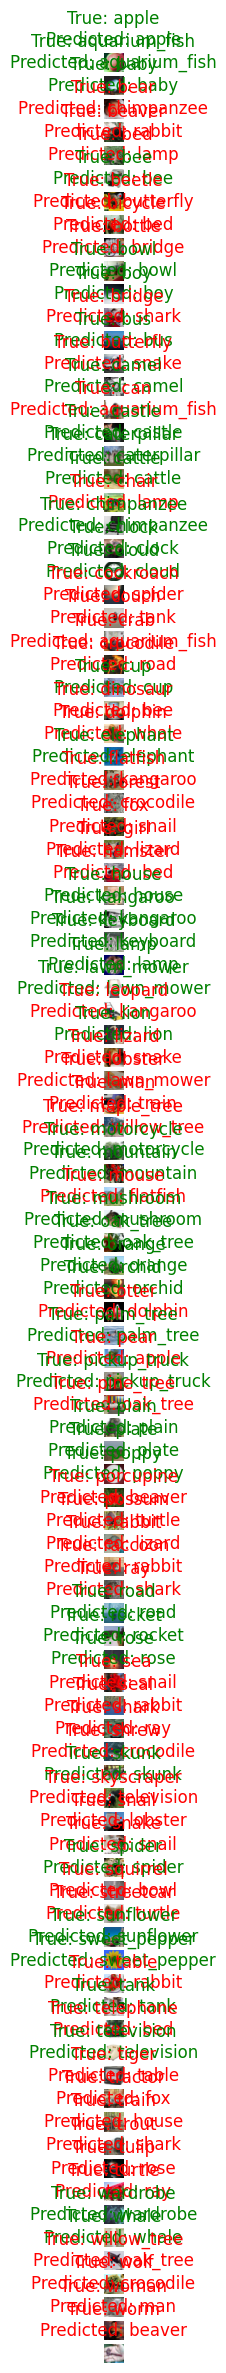

Nombre de bonnes prédictions : 44
Nombre de mauvaises prédictions : 56



Chargement du modèle : CNN simple.h5
313/313 [==============================] - 1s 2ms/step
Accuracy globale : 34.09%
               precision    recall  f1-score   support

        apple       0.40      0.72      0.52       100
aquarium_fish       0.30      0.52      0.38       100
         baby       0.29      0.19      0.23       100
         bear       0.16      0.26      0.20       100
       beaver       0.20      0.10      0.13       100
          bed       0.38      0.19      0.25       100
          bee       0.33      0.36      0.35       100
       beetle       0.49      0.26      0.34       100
      bicycle       0.31      0.50      0.38       100
       bottle       0.33      0.50      0.40       100
         bowl       0.32      0.09      0.14       100
          boy       0.35      0.09      0.14       100
       bridge       0.40      0.25      0.31       100
          bus       0.38      0.23   

C:\Users\yannv\AppData\Local\Temp\ipykernel_6344\2376312067.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


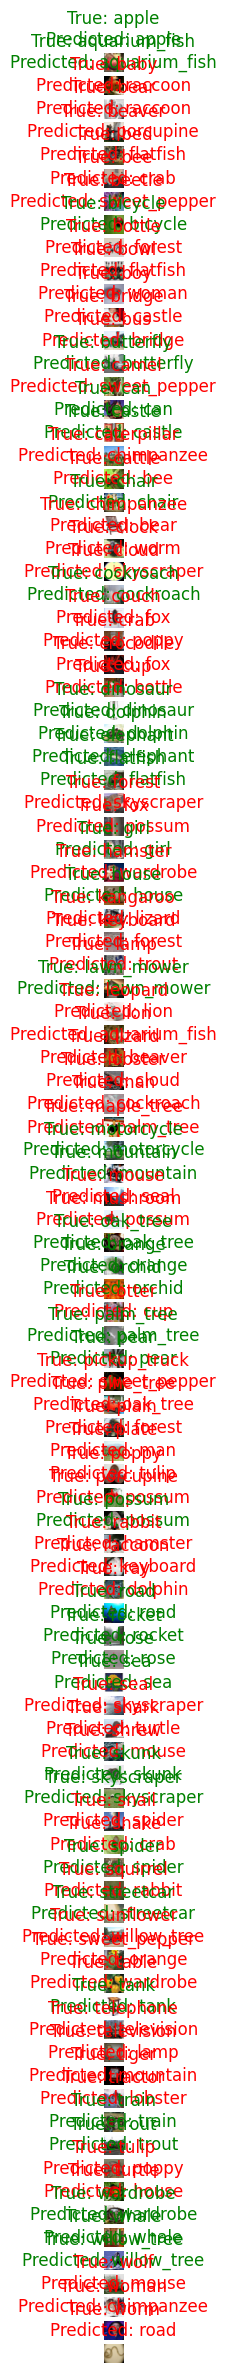

Nombre de bonnes prédictions : 37
Nombre de mauvaises prédictions : 63



Chargement du modèle : DenseNet121.h5
313/313 [==============================] - 11s 31ms/step
Accuracy globale : 56.17%
               precision    recall  f1-score   support

        apple       0.83      0.85      0.84       100
aquarium_fish       0.58      0.74      0.65       100
         baby       0.37      0.43      0.40       100
         bear       0.27      0.24      0.26       100
       beaver       0.31      0.18      0.23       100
          bed       0.63      0.57      0.60       100
          bee       0.52      0.54      0.53       100
       beetle       0.69      0.66      0.68       100
      bicycle       0.79      0.72      0.75       100
       bottle       0.82      0.55      0.66       100
         bowl       0.55      0.46      0.50       100
          boy       0.44      0.41      0.42       100
       bridge       0.53      0.68      0.60       100
          bus       0.53      0.42

C:\Users\yannv\AppData\Local\Temp\ipykernel_6344\2376312067.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


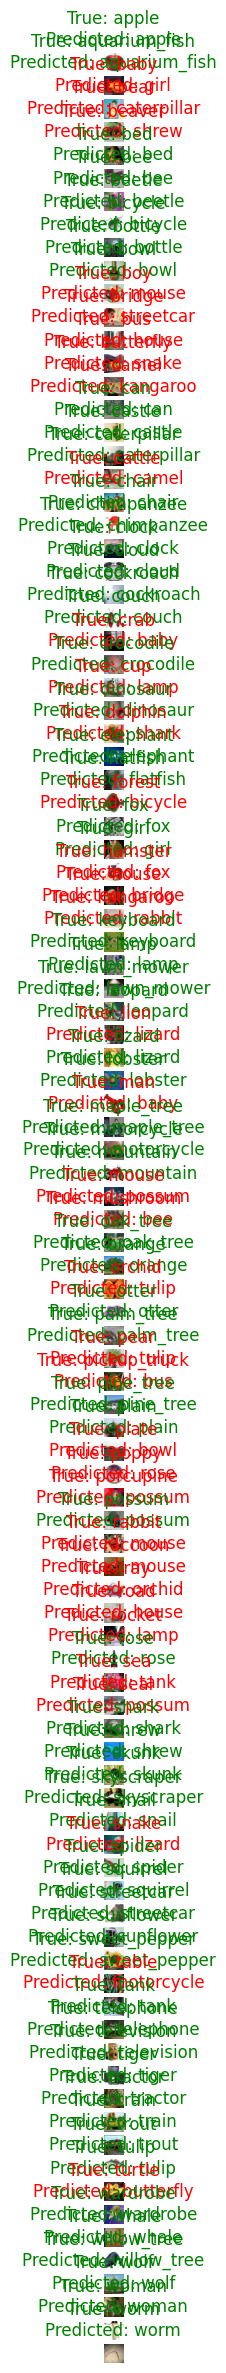

Nombre de bonnes prédictions : 64
Nombre de mauvaises prédictions : 36



Chargement du modèle : LeNet.h5
313/313 [==============================] - 0s 966us/step
Accuracy globale : 27.48%
               precision    recall  f1-score   support

        apple       0.47      0.54      0.50       100
aquarium_fish       0.33      0.26      0.29       100
         baby       0.25      0.24      0.24       100
         bear       0.15      0.09      0.11       100
       beaver       0.14      0.10      0.12       100
          bed       0.19      0.18      0.18       100
          bee       0.25      0.16      0.20       100
       beetle       0.29      0.29      0.29       100
      bicycle       0.35      0.26      0.30       100
       bottle       0.59      0.27      0.37       100
         bowl       0.16      0.09      0.12       100
          boy       0.21      0.19      0.20       100
       bridge       0.21      0.22      0.21       100
          bus       0.26      0.15      

C:\Users\yannv\AppData\Local\Temp\ipykernel_6344\2376312067.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


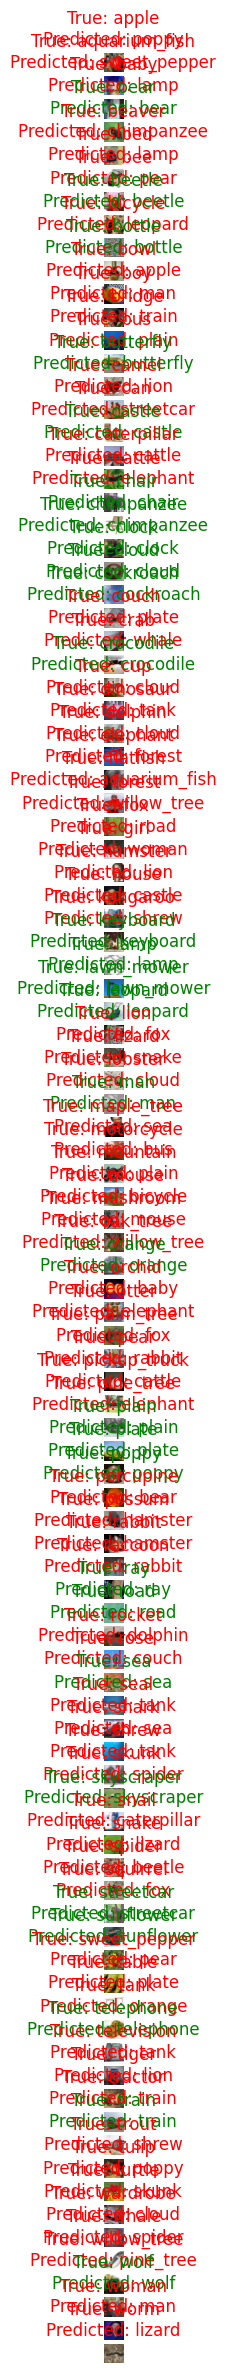

Nombre de bonnes prédictions : 29
Nombre de mauvaises prédictions : 71



Chargement du modèle : ResNet50.h5
313/313 [==============================] - 13s 40ms/step
Accuracy globale : 48.24%
               precision    recall  f1-score   support

        apple       0.90      0.63      0.74       100
aquarium_fish       0.50      0.54      0.52       100
         baby       0.25      0.34      0.29       100
         bear       0.25      0.22      0.23       100
       beaver       0.25      0.43      0.32       100
          bed       0.61      0.49      0.54       100
          bee       0.51      0.53      0.52       100
       beetle       0.61      0.49      0.54       100
      bicycle       0.48      0.75      0.59       100
       bottle       0.73      0.58      0.65       100
         bowl       0.46      0.36      0.40       100
          boy       0.25      0.21      0.23       100
       bridge       0.48      0.62      0.54       100
          bus       0.34      0.31   

C:\Users\yannv\AppData\Local\Temp\ipykernel_6344\2376312067.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


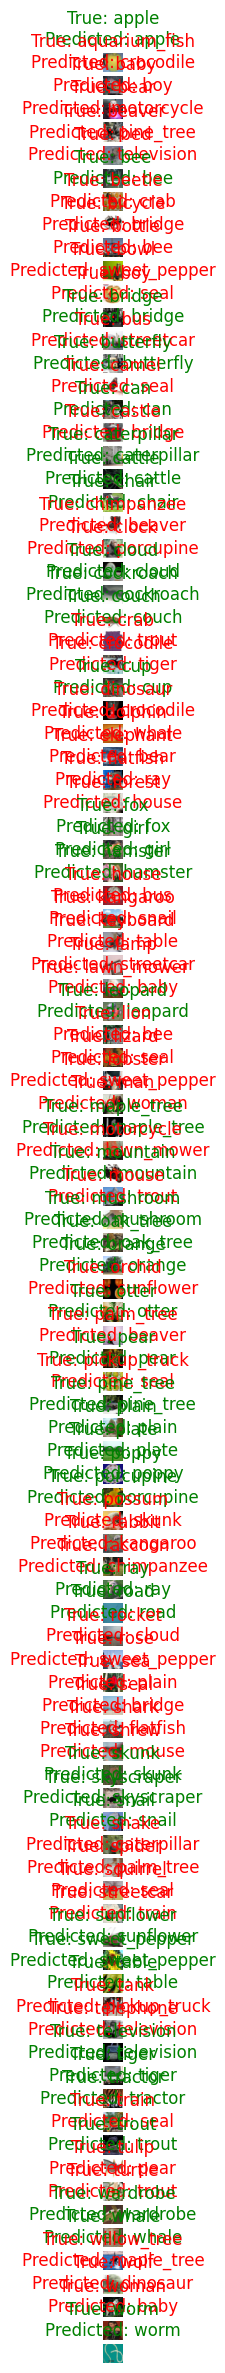

Nombre de bonnes prédictions : 43
Nombre de mauvaises prédictions : 57





In [12]:

# Chemin du dossier contenant les modèles sauvegardés
models_dir = '../models/cifar100'

# Liste des fichiers dans le dossier
model_files = os.listdir(models_dir)

# Boucle pour charger chaque modèle et afficher des images aléatoires
for model_file in model_files:
    if model_file.endswith('.h5'):

        # Construire le chemin complet vers le modèle
        model_path = os.path.join(models_dir, model_file)

        # Imprimer le nom du modèle chargé
        print(f"Chargement du modèle : {model_file}")
        
        # Charger le modèle
        loaded_model = tf.keras.models.load_model(model_path)
        
        evaluate_model(x_test, y_test, loaded_model, class_names)

        # Afficher des images aléatoires avec des prédictions pour ce modèle
        display_random_images_with_predictions_cifar100(x_test, y_test, class_names, loaded_model)
        print('\n\n')
